# Amazon Univarite Stock Forecasat with LSTM

# Install Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

# Load the Data

In [ ]:
df = pd.read_csv("/content/AMZN.csv")

In [ ]:
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,1997-05-15,0.121875,0.125000,0.096354,0.097917,1443120000
1,1,1997-05-16,0.098438,0.098958,0.085417,0.086458,294000000
2,2,1997-05-19,0.088021,0.088542,0.081250,0.085417,122136000
3,3,1997-05-20,0.086458,0.087500,0.081771,0.081771,109344000
4,4,1997-05-21,0.081771,0.082292,0.068750,0.071354,377064000


In [ ]:
df.tail()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
6830,6830,2024-07-09,199.399994,200.570007,199.050003,199.339996,32700100
6831,6831,2024-07-10,200.000000,200.110001,197.690002,199.789993,32883800
6832,6832,2024-07-11,200.089996,200.270004,192.860001,195.050003,44565000
6833,6833,2024-07-12,194.800003,196.470001,193.830002,194.490005,30554000
6834,6834,2024-07-15,194.542496,196.190002,190.830002,192.720001,38808123


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6835 entries, 0 to 6834
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6835 non-null   int64  
 1   Date        6835 non-null   object 
 2   Open        6835 non-null   float64
 3   High        6835 non-null   float64
 4   Low         6835 non-null   float64
 5   Close       6835 non-null   float64
 6   Volume      6835 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 373.9+ KB


In [ ]:
# Create a date range for filtering
start_date = '2023-07-01'
end_date = '2024-07-15'

# Convert 'date' column to datetime if it isn't already
df['Date'] = pd.to_datetime(df['Date'])

# Filter the DataFrame
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
print(filtered_df)


      Unnamed: 0       Date        Open        High         Low       Close  \
6575        6575 2023-07-03  130.820007  131.850006  130.070007  130.220001   
6576        6576 2023-07-05  130.240005  131.399994  129.639999  130.380005   
6577        6577 2023-07-06  128.250000  128.729996  127.370003  128.360001   
6578        6578 2023-07-07  128.589996  130.970001  128.130005  129.779999   
6579        6579 2023-07-10  129.070007  129.279999  125.919998  127.129997   
...          ...        ...         ...         ...         ...         ...   
6830        6830 2024-07-09  199.399994  200.570007  199.050003  199.339996   
6831        6831 2024-07-10  200.000000  200.110001  197.690002  199.789993   
6832        6832 2024-07-11  200.089996  200.270004  192.860001  195.050003   
6833        6833 2024-07-12  194.800003  196.470001  193.830002  194.490005   
6834        6834 2024-07-15  194.542496  196.190002  190.830002  192.720001   

        Volume  
6575  28264800  
6576  35895400  


In [ ]:
df = filtered_df.copy()

In [ ]:
# Preprocessing data (focus on 'Close' price)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df[['Close']].values

# Preprocess the Data

In [ ]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:
# Prepare training and test datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [ ]:
# Create dataset matrix for LSTM
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [ ]:
look_back = 10
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

In [ ]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM Model

In [ ]:
# Building the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(Dense(25))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model

In [ ]:
# Fit the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1725
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0165
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0167
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0144
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0090
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0072
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0057
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0055
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0077
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0058
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0053
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0059
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0057
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0055
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━

# Prediction

In [ ]:
y_pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step


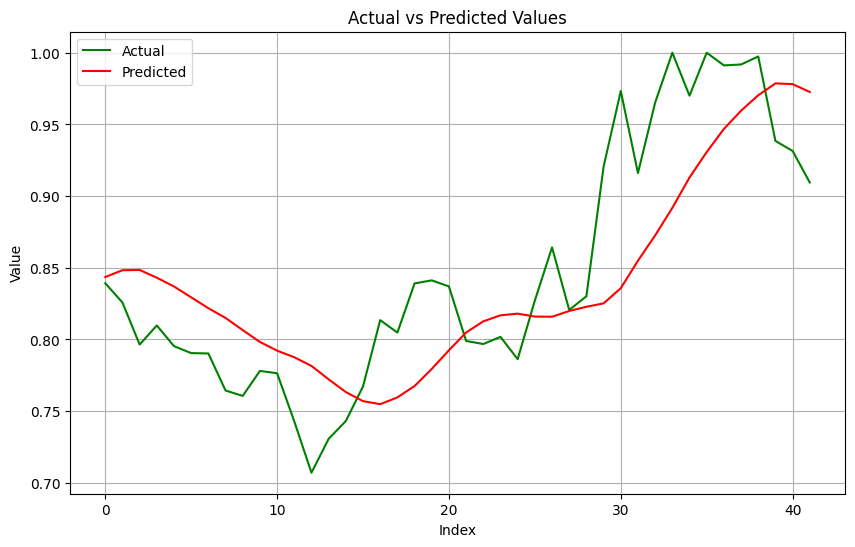

In [ ]:
plt.figure(figsize=(10, 6))  # Set the size of the figure

# Plot the test data
plt.plot(y_test, color='green', label='Actual')

# Plot the predicted data
plt.plot(y_pred, color='red', label='Predicted')

# Add titles and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')

# Add a legend
plt.legend()

# Show grid lines for better readability
plt.grid(True)

# Display the plot
plt.show()


# Next 30 Days Forecasting

In [ ]:
# Forecasting the next 30 days
def forecast_next_days(model, last_sequence, days=30):
    forecasted = []
    current_sequence = last_sequence

    for _ in range(days):
        predicted_value = model.predict(current_sequence[np.newaxis, :, :])[0, 0]
        forecasted.append(predicted_value)
        current_sequence = np.append(current_sequence[1:], predicted_value).reshape(-1, 1)

    return forecasted



In [ ]:
# Use the last available data point for forecasting
last_sequence = X_test[-1]
predicted_values = forecast_next_days(model, last_sequence, days=30)

# Inverse scale the predicted values
predicted_values_rescaled = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

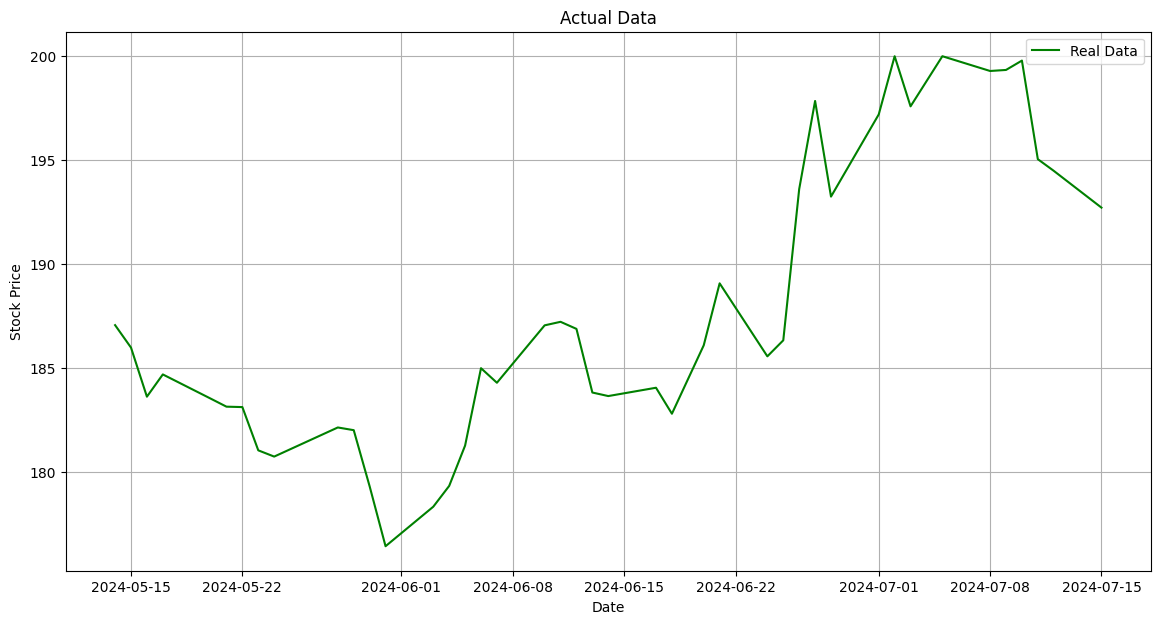

In [ ]:
# Plot the results
plt.figure(figsize=(14,7))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(test_data[look_back:]), label='Real Data',color='green')

plt.title('Actual Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()

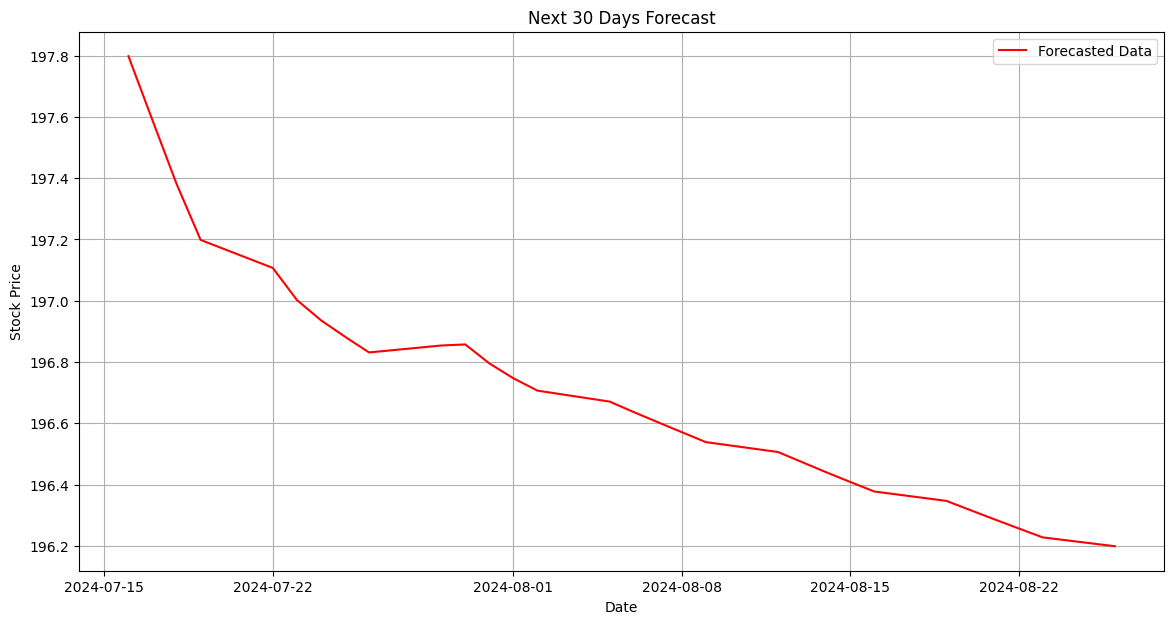

In [ ]:
# Plot the results
plt.figure(figsize=(14,7))
plt.plot(pd.date_range(df.index[-1], periods=31, freq='B')[1:], predicted_values_rescaled, label='Forecasted Data',color='red')
plt.title('Next 30 Days Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()

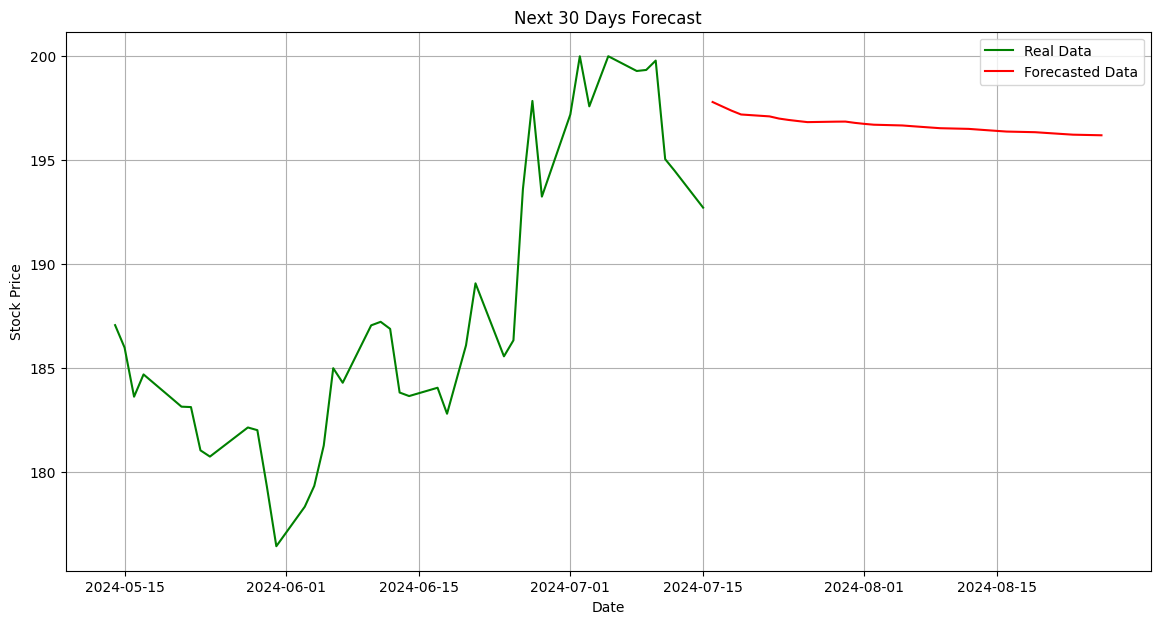

In [ ]:
# Plot the results
plt.figure(figsize=(14,7))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(test_data[look_back:]), label='Real Data',color='green')
plt.plot(pd.date_range(df.index[-1], periods=31, freq='B')[1:], predicted_values_rescaled, label='Forecasted Data',color='red')
plt.title('Next 30 Days Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()

# Next 90 Days Forecast

In [ ]:
# Use the last available data point for forecasting
last_sequence = X_test[-1]
predicted_values = forecast_next_days(model, last_sequence, days=90)

# Inverse scale the predicted values
predicted_values_rescaled = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

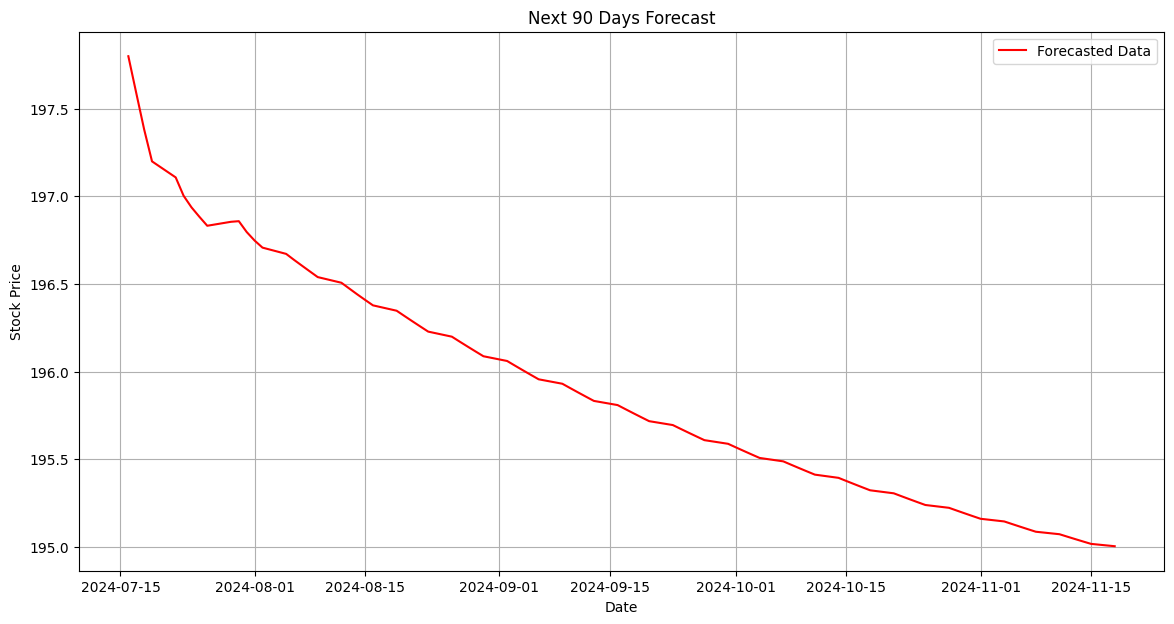

In [ ]:
# Plot the results
plt.figure(figsize=(14,7))

plt.plot(pd.date_range(df.index[-1], periods=91, freq='B')[1:], predicted_values_rescaled, label='Forecasted Data',color='red')
plt.title('Next 90 Days Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()

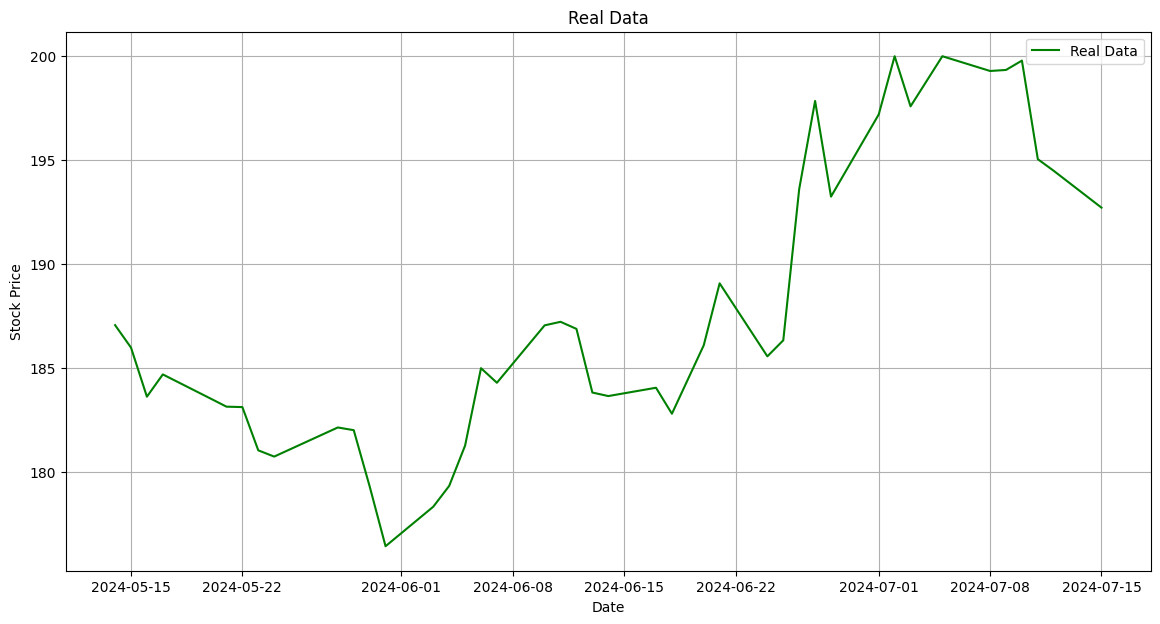

In [ ]:
# Plot the results
plt.figure(figsize=(14,7))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(test_data[look_back:]), label='Real Data',color='green')
plt.title('Real Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

plt.show()

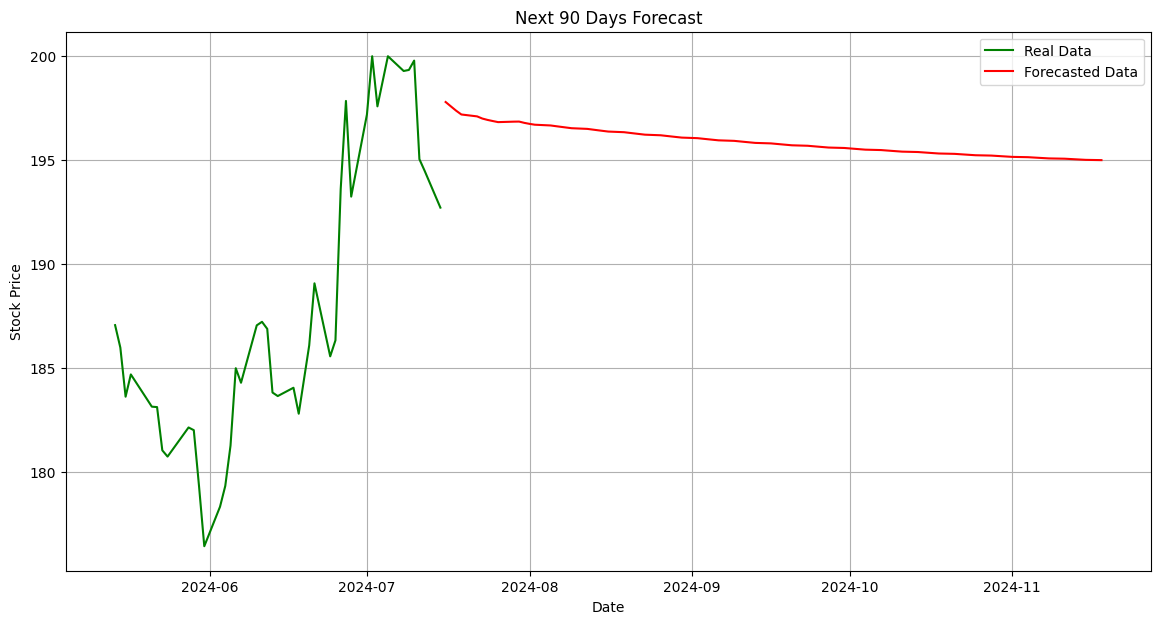

In [ ]:
# Plot the results
plt.figure(figsize=(14,7))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(test_data[look_back:]), label='Real Data',color='green')
plt.plot(pd.date_range(df.index[-1], periods=91, freq='B')[1:], predicted_values_rescaled, label='Forecasted Data',color='red')
plt.title('Next 90 Days Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()